In [1]:
import numpy as np
import librosa
import pretty_midi
import matplotlib.pyplot as plt
import IPython.display as ipd
import sounddevice as sd
import librosa.display
import math
import scipy
import time
from scipy import signal

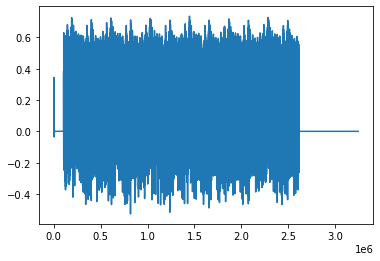

In [3]:
# Importing audio file
s, r = librosa.load('./Files/py5-Bass synth.wav', sr=sr)

# Importing MIDI

#pm = pretty_midi.PrettyMIDI('filename.mid')
plt.plot(s)

In [4]:

# Fade in and out function to avoid clips when we merge segments

def fade(segment, fadesize):
    fades = np.array([])
    fadesize = fadesize
    if segment.size <= (fadesize*2):
        fadesize = int(segment.size / 10)
        midpart = np.ones(segment.size - (int(fadesize*2)))
        fadein = np.linspace(0,1,num=fadesize)
        fadeout = np.linspace(1,0,num=fadesize)
        fades = np.concatenate((fadein, midpart, fadeout))
        
    else:         
        midpart = np.ones(segment.size - (int(fadesize*2)))   
        fadein = np.linspace(0,1,num=fadesize)
        fadeout = np.linspace(1,0,num=fadesize)
        fades = np.concatenate((fadein, midpart, fadeout))
        
    y = segment * fades
    
    return y


def sizecheck(segment, result):
    if segment.size != result.size:
        if segment.size > result.size:
            diff = segment.size-result.size            
            segment = np.delete(segment_final, diff)
            
        elif result.size > segment.size:
            zeros= np.zeros(result.size - segment.size)
            
            segment = np.concatenate((segment, zeros))
    else:
        pass
    
    return segment

In [5]:
# Just added a compressor function because I wanted to try it out. Can be used for processing 

def compressor(audio, threshold, makeup, smoothness):
    x = np.array([])
    x = np.append(x, audio)
    for i in range(smoothness):
        index = 0        
        for i in x:        
            if np.abs(i) >= threshold + 0.3:
                x[index] = i * 0.85                 
            elif np.abs(i) >= threshold + 0.2:
                x[index] = i * 0.90            
            elif np.abs(i) >= threshold + 0.1:
                x[index] = i * 0.95            
            elif np.abs(i) >= threshold:
                x[index] = i * 0.99            
            else:
                x[index] = i
            index += 1
            
    y = x * (1+makeup)
    
    return y


# Try impulses between 2 and 10
def IRDelay(audio, impulses,sr=sr):    
    
    impulse_array = np.linspace(0.2, 0, num=impulses)
    IRarray = np.array([])
    size = int(audio.size/impulses)-1
    for i in range(impulses):
    
        IRarray = np.append(IRarray, np.zeros(size))
        IRarray = np.append(IRarray, impulse_array[i]) 
    
    # Y =signal.fft.sfft(audio)
    # H = signal.fft.sfft(IRarray)
    # store = Y*H
    # audio = signal.fft.isfft(store) 
    x = np.convolve(audio, IRarray)
    audio = np.append(audio, np.zeros([x.size-audio.size]))
    s = (audio+(x*0.75)*0.5)
    
    return x

def allpass(delay, gain):
    b = np.zeros(delay)
    b[0] = gain
    b[delay-1] = 1
    a = np.zeros(delay)
    a[0] = 1
    a[delay-1] = gain
    return b,a


def IIRReverb(audio, wet, combq, delay1, gain1, delay2, gain2):
    s_tail = audio
    s_tail = np.append(s_tail, np.zeros(48000))    
    
    # First comb filter
    f0 = 200  
    Q = combq  
    b1,a1 = signal.iircomb(f0, Q, ftype='notch', fs=sr)
    y1 = signal.lfilter(b1,a1,s_tail)
    # Second comb filter 
    f0 = 300  
    Q = combq  
    b2,a2 = signal.iircomb(f0, Q, ftype='notch', fs=sr)
    y2 = signal.lfilter(b2,a2,s_tail)
    # Third comb filter
    f0 = 400  
    Q = combq  
    b3,a3 = signal.iircomb(f0, Q, ftype='notch', fs=sr)
    y3 = signal.lfilter(b3,a3,s_tail)
    # Fourth comb filter
    f0 = 500 
    Q = combq  
    b4,a4 = signal.iircomb(f0, Q, ftype='notch', fs=sr)
    y4 = signal.lfilter(b4,a4,s_tail)
    # computing up the parallell structure by adding them together (and scaling the amplitude)
    comb_result = (y1 + y2 + y3 + y4)*0.2
    # Designing the two allpass filters
    b1,a1 = allpass(delay1, gain1)
    b2,a2 = allpass(delay2, gain2)

    # Convolving the coefficients to get the cascading structure
    cascade_a = np.convolve(a1,a2)
    cascade_b = np.convolve(b1,b2)

    # Run the result from the comb parallell filters through the cascade of allpass filters
    signal_output = signal.lfilter(cascade_b, cascade_a, comb_result)
    # Merging wet with dry
    #audio = np.append(audio, np.zeros([signal_output.size-audio.size]))
    #output = ((signal_output * wet)+audio)*0.5
    
    
    return signal_output


def framecompressor(audio, frame_length, threshold, ratio, makeup):
    window = signal.get_window('hann', frame_length)    
    b = np.array([-ratio])
    c = signal.convolve(window, b)
    window = c + 1
    
    x = np.array([])
    x = np.append(x, audio)
    
    for i in range(0, len(audio), int(frame_length*0.5)):
                
        s = x[i:i + frame_length]        
        a = np.max(np.abs(s))
        if a > threshold:            
            s = s * window
            x[i:i+frame_length] = s
        
    compressed = x * makeup
    return compressed

def reverse(audio):
    s = np.flip(audio)
    return s


def softClipper(audio, drive, output=0.8):

    """audio = Source to be SoftClipped
    drive = Amount of SoftClipping (Try between 10-40)
    output = Output volume
    
    The signal is normalized before output attenuation for better control.
    """
    
    # Drive can not be set to 0
    if drive == 0:
        drive = 1
    
    piDivisor = 2 / np.pi
    driver = np.arctan(audio * drive)
    
    softclip = piDivisor * driver
    
    normalized = softclip/np.max(softclip)
    softClipped = normalized * output
    
    return softClipped
    

In [6]:
#b = IIRReverb(s, 0.9, 20, 800, 0.78, 1700, 0.68)
#xx = IRDelay(s, 4)
#first = framecompressor(s, 2048,0.45, 0.6, 1.7)
#sd.play(first)
#plt.plot(first)

#sd.play(b)
#sd.wait()
#sd.play(xx)

In [7]:
# If we want to resynthesize anything these can come in handy


def sawtooth_synth(freq, dur_ms, sr=sr, amp=1, phase=1):
    t = np.arange(0, dur_ms/1000, 1/sr)
    s = amp * signal.sawtooth(2 *np.pi*freq*t*phase)

    return s

def triangle_synth(freq, dur_ms, sr=sr, amp=1, phase=1, width=0.5):
    t = np.arange(0, dur_ms/1000, 1/sr)
    s = amp * signal.sawtooth(2 *np.pi*freq*t*phase)

    return s

def sine_synth(freq, dur_ms, sr=sr, amp=1, phase=1):
    t = np.arange(0, dur_ms/1000, 1/sr)
    s = amp*np.sin(2*np.pi*freq*t*phase)
    
    return s
    

def square_synth(freq, dur_ms, sr=sr, amp=1, phase=1):
    t = np.arange(0, dur_ms/1000, 1/sr)
    s = amp*signal.square(2*np.pi*freq*t*phase)
    
    return s


# Repurposing the sine_synth as a LFO (for PWM).
def myLFO(lfo_hz, dur_ms, lfo_depth):
    if lfo_depth < 0.01:
        lfo_depth = 0.01
    elif lfo_depth > 0.99:
        lfo_depth = 0.99
    lfo = sine_synth(lfo_hz, dur_ms, amp=lfo_depth)
    
    return lfo


def myPWM(freq, lfo_hz, dur_ms, lfo_depth=0.9):
    t = np.linspace(0, 1, sr*(int(dur_ms/1000)), endpoint=False)
    lfo = myLFO(lfo_hz, dur_ms, lfo_depth)
    pwm = signal.square(2 * np.pi * freq * t, duty=(lfo + 1)/4)
    
    return pwm


def chirp_sound(freq_start, freq_end, dur_ms, amp=1):
    
    t = np.arange(0, int((dur_ms/1000)*sr)) / sr
    s = amp * signal.chirp(t, f0=freq_start, f1=freq_end, t1=dur_ms/1000, method='linear')

    return s

# Multiply the amp_envelope with your generated signal note by note 
# to get a nice smooth attack and decay

def amp_envelope(dur_ms, sr=sr):
    
    t = np.arange(0, dur_ms/1000, 1/sr)
    
    # Splitting t up into 4 parts
    attack_length = int(len(t) / 20)
    decay_length = int(len(t) / 4)
    sustain_length = int(len(t) / 2)
    release_length = int(len(t) - (attack_length + decay_length + sustain_length))
    
    # Setting the start and stop amplitube values for the ramps
    attack = np.linspace(0, 0.9, num=attack_length)
    decay = np.linspace(0.9, 0.75, num=decay_length)
    sustain = np.linspace(0.75, 0.6, num=sustain_length)
    release = np.linspace(0.6, 0, num=release_length)
    
    # Putting them together in order
    env = np.concatenate((attack, decay, sustain, release))
    
    return env

### PWM & SoftClip-test below (for deletion)

In [8]:
PWMtest = myPWM(330, 1, 2000, 0.95)

sd.play(PWMtest)
sd.wait()

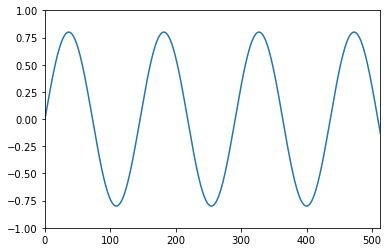

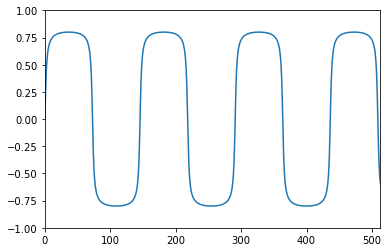

In [9]:
twosecsine = sine_synth(330, 2000, amp=0.8)

sinedrive = softClipper(twosecsine, 15)

# original
plt.plot(twosecsine)
plt.axis(ymin=-1, ymax=1, xmin=0, xmax=512)
plt.show()
sd.play(twosecsine)
sd.wait()

# softclipped
plt.plot(sinedrive)
plt.axis(ymin=-1, ymax=1, xmin=0, xmax=512)
plt.show()
sd.play(sinedrive)
sd.wait()

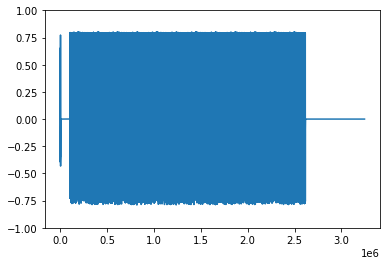

In [10]:
musicdrive = softClipper(s, 30)

plt.plot(musicdrive)
plt.axis(ymin=-1, ymax=1)
plt.show()
sd.play(musicdrive)

---

In [11]:
#loading midi and displaying info

pm = pretty_midi.PrettyMIDI('./Files/py5.midi')


In [12]:
# Actual bpm is 110, this returns 221.5
print(pm.estimate_tempo())

downbeats_in_seconds = pm.get_downbeats()
print(downbeats_in_seconds.size)
downbeats_sample_time = downbeats_in_seconds*48000
downbeats_sample_time = downbeats_sample_time. astype(int)
downbeats_sample_time = downbeats_sample_time[1:]
print(downbeats_sample_time)


221.53419267088816
29
[ 104727  209454  314181  418908  523635  628363  733090  837817  942544
 1047271 1151998 1256726 1361453 1466180 1570907 1675634 1780361 1885089
 1989816 2094543 2199270 2303997 2408724 2513452 2618179 2722906 2827633
 2932360]


In [13]:
s.size


3246546

104727
0
209454
1
314181
2
418908
3
523635
0
628363
1
733090
2
837817
3
942544
0
1047271
1
1151998
2
1256726
3
1361453
0
1466180
1
1570907
2
1675634
3
1780361
0
1885089
1
1989816
2
2094543
3
2199270
0
2303997
1
2408724
2
2513452
3
2618179
0
2722906
1
2827633
2
2932360
3


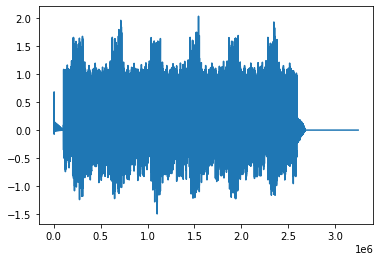

In [14]:
# Have patience, it takes some time

# Creating the result array I will add all signals back into
result = np.zeros(s.size) 

# Temporary arrays used in the for loop
segment = np.array([])
seg = np.array([])

# Making the counter
counter = 0
current_beat = 0
overlap = 0
overlap_length = 1024

# Just iterating through a random list, we'll use info from the midifile for this 

# This is the main slicing and processing part of the program

for i in downbeats_sample_time:
    # To check computational time and where it struggles
    print(i)
    print(counter)
    
    counter += 1
    
    # Slicing the segment from current_beat to the sample position i
    seg = s[current_beat:i]    
    # adding fade ins and outs to the segment
    segment = fade(seg, overlap_length)
    if counter == 1:
        segment = compressor(segment, 0.3, 1, 1)
        seg_fx = IRDelay(segment, 8)
        segment_padded = np.pad(segment,[current_beat, s.size-(current_beat+segment.size)]) 
        segment_fx = np.pad(seg_fx,[current_beat, s.size-(current_beat+seg_fx.size)])
          
        segment_padded = (segment_padded + segment_fx)
        
    elif counter == 2:
        segment = compressor(segment, 0.3, 1, 1)
        segment_padded = np.pad(segment,[current_beat, s.size-(current_beat+segment.size)])
    elif counter == 3:
        segment = compressor(segment, 0.3, 1, 1)
        seg_fx = IIRReverb(segment, 0.9, 20, 800, 0.78, 1700, 0.68)
        segment_padded = np.pad(segment,[current_beat, s.size-(current_beat+segment.size)]) 
        segment_fx = np.pad(seg_fx,[current_beat, s.size-(current_beat+seg_fx.size)])
          
        segment_padded = (segment_padded + segment_fx)

    elif counter == 4: 
#        # Arvid processing goes in here
        #segment = reverse(segment)
        segment = compressor(segment, 0.3, 1, 1)
        segment = reverse(segment)
        segment_padded = np.pad(segment,[current_beat, s.size-(current_beat+segment.size)])
#        segment_padded = IIRReverb(segment_padded, 20, 1000, 0.8, 3400, 0.7)
    
    # Setting overlap to for example 100 samples, just some ideas for the overlap
    
    # updating the current beat for the next loop
    current_beat = current_beat + seg.size
    
    segment_overlapped = segment_padded[overlap:segment_padded.size]
    
    # getting the size right again by adding zeros to the end:
    segment_final = np.pad(segment_overlapped, [0, overlap])
    # Increasing overlap for next round of for loop 
    overlap = overlap + overlap_length
    
    # Just making sure the sizes are allright 
    segment_final = sizecheck(segment_final, result)
    
    # Resetting the counter when it reaches 4
    if counter == 4:
        counter = 0
    # pasting the segments back in, one by one
    result = result + segment_final
    
# Playing back the result
    
#final = framecompressor(result, 2048,0.40, 0.5, 1.7)   
sd.play(result)
plt.plot(result)



In [15]:
print(result.size)
print(result.shape)
print(s.size)
print(s.shape)

3246546
(3246546,)
3246546
(3246546,)


In [16]:
print(type(seg))

<class 'numpy.ndarray'>


In [17]:
class Segment(np.ndarray):
    def __new__(cls, *args):
        pass
    def __init__(self, position, audio):
        self.position = position
        self.audio = audio
    def __array_finalize__(self, obj):
        pass
            
    #def audioslicer(self, iterative):
       # y = self.audio[self.position:iterative]
    
    def fading(self, fadesize):
        fades = np.array([])
        fadesize = fadesize
        if self.size <= (fadesize*2):
            fadesize = int(self.size / 10)
            midpart = np.ones(self.size - (int(fadesize*2)))
            fadein = np.linspace(0,1,num=fadesize)
            fadeout = np.linspace(1,0,num=fadesize)
            fades = np.concatenate((fadein, midpart, fadeout))
        
        else:         
            midpart = np.ones(self.size - (int(fadesize*2)))   
            fadein = np.linspace(0,1,num=fadesize)
            fadeout = np.linspace(1,0,num=fadesize)
            fades = np.concatenate((fadein, midpart, fadeout))
        
        y = self.audio * fades
    
        return y

    def sizechecker(self, result):
        if self.size != result.size:
            if self.size > result.size:
                diff = self.size-result.size            
                y = np.delete(self, diff)
            
            elif result.size > self.size:
                zeros= np.zeros(result.size - self.size)
            
                y = np.concatenate((segment, zeros))
        else:
            pass
    
        return y
        
    
    def padder(self, audiototal):
        y = np.pad(self, [self.position, audiototal.size-(self.position+self.size)])
        return y

    def overlapper(self, overlap):
        x = self[overlap:self.size]
        y = np.pad(x, [0, overlap])
        return y
        

In [18]:
i = 48000
position = 4500
fadesize = 250
seg = Segment(position, s[position:i])
#seg = np.append(seg, s[position:i])
print(seg.size)
print(seg.shape)
print(seg)
#seg = Segment(position,s)
#seg = seg.audioslicer(i)
seg = Segment.fading(seg,fadesize)
print(seg.size)
seg = Segment.padder(current_beat, s)
print(seg.size)

AttributeError: 'NoneType' object has no attribute 'size'

In [ ]:
# Creating the result array I will add all signals back into
result = np.zeros(s.size) 

# Temporary arrays used in the for loop
segment = np.array([])
seg = np.array([])

# Making the counter
counter = 0
current_beat = 0
overlap = 0
overlap_length = 1024

# Just iterating through a random list, we'll use info from the midifile for this 

# This is the main slicing and processing part of the program

for i in my_list:
    # To check computational time and where it struggles
    print(i)
    print(counter)
    
    counter += 1
    
    # Slicing the segment from current_beat to the sample position i
    seg = s[current_beat:i]    
    # adding fade ins and outs to the segment
    segment = fade(seg, overlap_length)
    if counter == 1:
        segment = compressor(segment, 0.3, 1.2, 1)
        seg_fx = IRDelay(segment, 8)
        segment_padded = np.pad(segment,[current_beat, s.size-(current_beat+segment.size)]) 
        segment_fx = np.pad(seg_fx,[current_beat, s.size-(current_beat+seg_fx.size)])
          
        segment_padded = (segment_padded + segment_fx)
        
    elif counter == 2:
        segment = compressor(segment, 0.3, 1.2, 1)
        segment_padded = np.pad(segment,[current_beat, s.size-(current_beat+segment.size)])
    elif counter == 3:
        segment = compressor(segment, 0.3, 1.2, 1)
        seg_fx = IIRReverb(segment, 0.9, 20, 800, 0.78, 1700, 0.68)
        segment_padded = np.pad(segment,[current_beat, s.size-(current_beat+segment.size)]) 
        segment_fx = np.pad(seg_fx,[current_beat, s.size-(current_beat+seg_fx.size)])
          
        segment_padded = (segment_padded + segment_fx)

    elif counter == 4: 
#        # Arvid processing goes in here
        #segment = reverse(segment)
        segment = compressor(segment, 0.3, 1.2, 1)
        segment_padded = np.pad(segment,[current_beat, s.size-(current_beat+segment.size)])
#        segment_padded = IIRReverb(segment_padded, 20, 1000, 0.8, 3400, 0.7)
    
    # Setting overlap to for example 100 samples, just some ideas for the overlap
    
    # updating the current beat for the next loop
    current_beat = current_beat + seg.size
    
    segment_overlapped = segment_padded[overlap:segment_padded.size]
    
    # getting the size right again by adding zeros to the end:
    segment_final = np.pad(segment_overlapped, [0, overlap])
    # Increasing overlap for next round of for loop 
    overlap = overlap + overlap_length
    
    # Just making sure the sizes are allright 
    segment_final = sizecheck(segment_final, result)
    
    # Resetting the counter when it reaches 4
    if counter == 4:
        counter = 0
    # pasting the segments back in, one by one
    result = result + segment_final
    
# Playing back the result
    
#final = framecompressor(result, 2048,0.40, 0.5, 1.7)   
sd.play(result)
plt.plot(result)



## Visualizations

#### Audacity (Peak + RMS)

In [28]:
# Import features.py to access our RMS-function
import features

In [20]:
## A function to display in the style of Audacity

def vizAudacity(audio):

    frame_length = 512
    
    # Finding the RMS
    rms_values = features.root_mean_square(audio, 2048, frame_length)
    
    # Making a waveform with the RMS values
    rms_audio = []
    count = 0
    
    for i in range(0, len(s), frame_length): #in your case 512
        chunk = s[i:i + frame_length]
        try:
            a = rms_values[count]*chunk
        except:
            break
        rms_audio = np.append(rms_audio, a)
        count += 1
    
    # Choosing style and colors for the plot
    plt.style.use('seaborn-white')
    fig, ax = plt.subplots(figsize=(16, 4), facecolor='#e7e7e7', dpi=150.0)
    ax.set_facecolor('#c0c0c0')

    # Setting labels
    ax.set_title("Audacity style waveform", fontsize='24', weight='roman', y=1.02, family='monospace')
    ax.set_xmargin(0.005)

    # Plotting the outer waveform (Peak/Amplitude)
    ax.plot(audio, color='#3132c1')

    # Plotting the inner waveform (RMS)
    ax.plot(rms_audio, color='#6464d5')

    # Generating lists for showing x-axis ticks every 15 sec,
    # by finding the floor value of (length // 15) + 1 for the np.arange().
    tick_stop = ((len(s)/sr)//15)+1
    s_ticks_value = np.arange(sr*15,sr*15*tick_stop,sr*15)
    s_ticks = np.arange(int(15),int(15*tick_stop),15)

    # Showing minutes instead of samples
    ax.set_xticks(s_ticks_value)
    ax.set_xticklabels(s_ticks)
    ax.axis(ymin=-1, ymax=1)

    # Displaying the plot
    fig.tight_layout()
    plt.show()

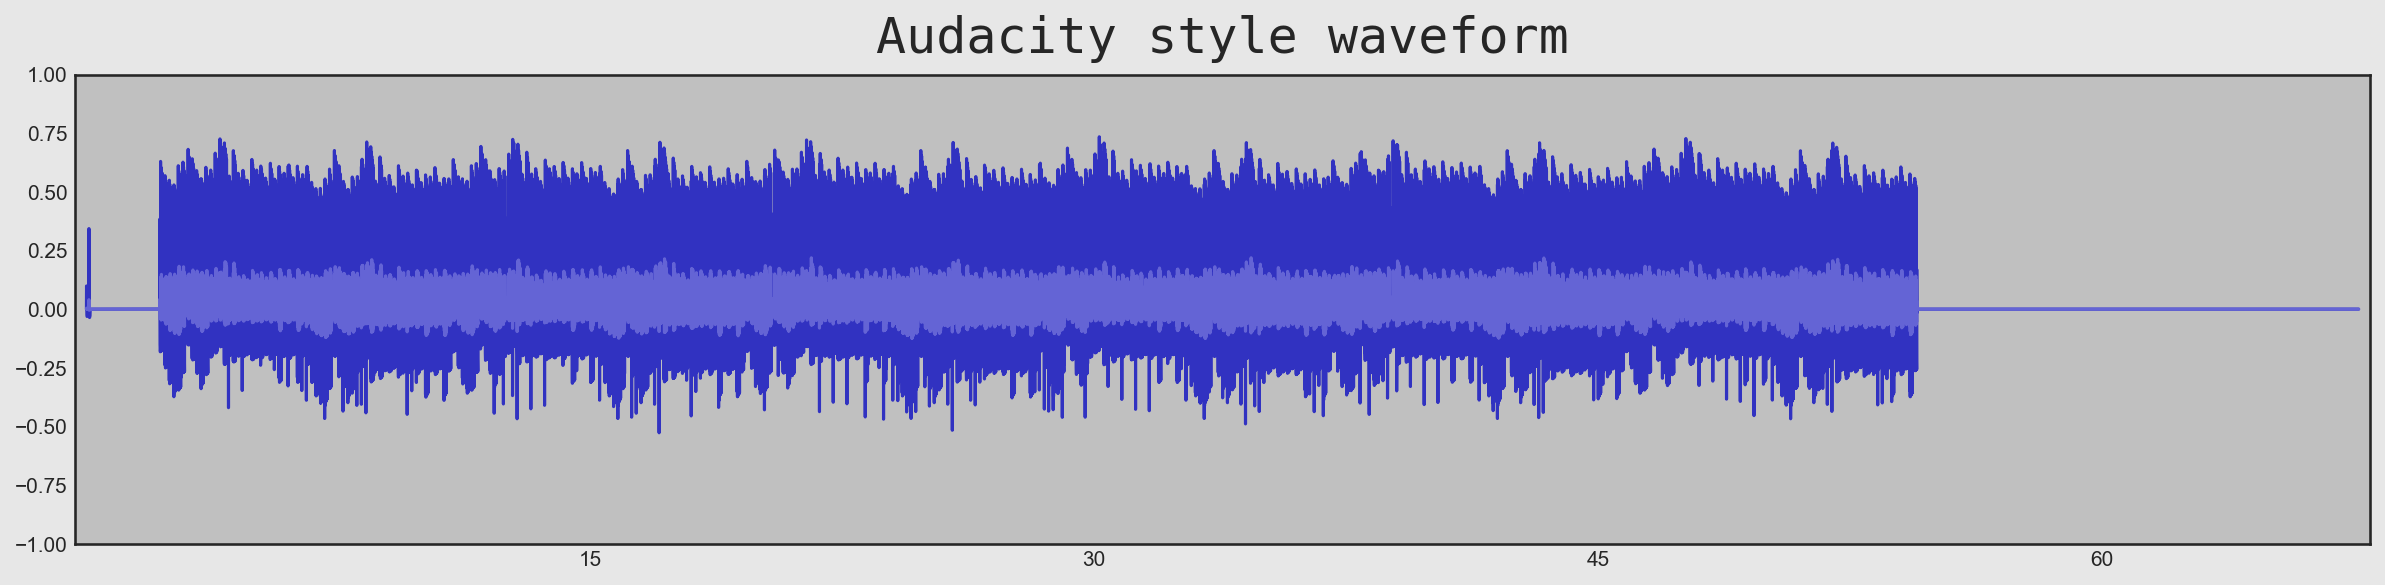

In [21]:
vizAudacity(s)

#### Traktor/Serato (Colored by Spectral Centroid)
```Colored Waveforms

Colors in the waveform show the frequency of the sound:
bass is red, mids are green, treble is blue.
                                        (www.serato.com)
```


In [26]:
def vizSerato(audio, sr):

    # Locate note onset events by picking peaks in an onset strength envelope
    onsets = librosa.onset.onset_detect(y=audio, sr=sr, units='samples', backtrack=True, 
                                        wait=1, pre_avg=1, post_avg=1, pre_max=5, post_max=5)

    if len(onsets) > 80:
        onsets = librosa.onset.onset_detect(y=audio, sr=sr, units='samples', backtrack=True, 
                                        wait=20, pre_avg=1, post_avg=1, pre_max=5, post_max=5)
    
    # Choosing style and colors for the plot
    plt.style.use('seaborn-white')
    fig, ax = plt.subplots(figsize=(16, 4), facecolor='#373737', dpi=150.0)
    ax.set_facecolor('#000000')
    
    # Setting labels
    ax.set_title("Serato/Traktor style waveform", fontsize='24', weight='roman', y=1.02, family='monospace', color='#f4f4f4')
    ax.set_xmargin(0.005)
    
    for i in range(len(onsets)-1):

        segment = audio[onsets[i]:onsets[i+1]]

        # Compute spectral centroid for each segment
        centroid = librosa.feature.spectral_centroid(segment, sr=sr, n_fft=len(segment), hop_length=len(segment)+1)[0]
        x = np.pad(segment, (onsets[i], 0), 'constant')

        if centroid <= 59: # Sub Low
            plt.plot(x, color='#113450')

        elif 60 <= centroid <= 249: # Low
            plt.plot(x, color='#4978c0')

        elif 250 <= centroid <= 799: # Low Mid
            plt.plot(x, color='#8a61d3')        

        elif 800 <= centroid <= 3999: # Mid
            plt.plot(x, color='#199eb0')

        elif 4000 <= centroid <= 5999: # High Mid
            plt.plot(x, color='#ffc0cb')

        elif 6000 <= centroid: # High
            plt.plot(x, color='#68e17f')
            
    # Generating lists for showing x-axis ticks every 15 sec,
    # by finding the floor value of (length // 15) + 1 for the np.arange().
    tick_stop = ((len(s)/sr)//1)+1
    s_ticks_value = np.arange(0,sr*1*tick_stop,sr*1)
    s_ticks = np.arange(int(0),int(1*tick_stop),1)

    # Showing minutes instead of samples
    ax.set_xticks(s_ticks_value)
    ax.set_xticklabels(s_ticks, color='#f4f4f4')
    ax.tick_params(axis='y', colors='#f4f4f4')
    ax.set_xlabel('Time (seconds)', color='#f4f4f4')
    ax.axis(ymin=-1, ymax=1)

    return plt.show()

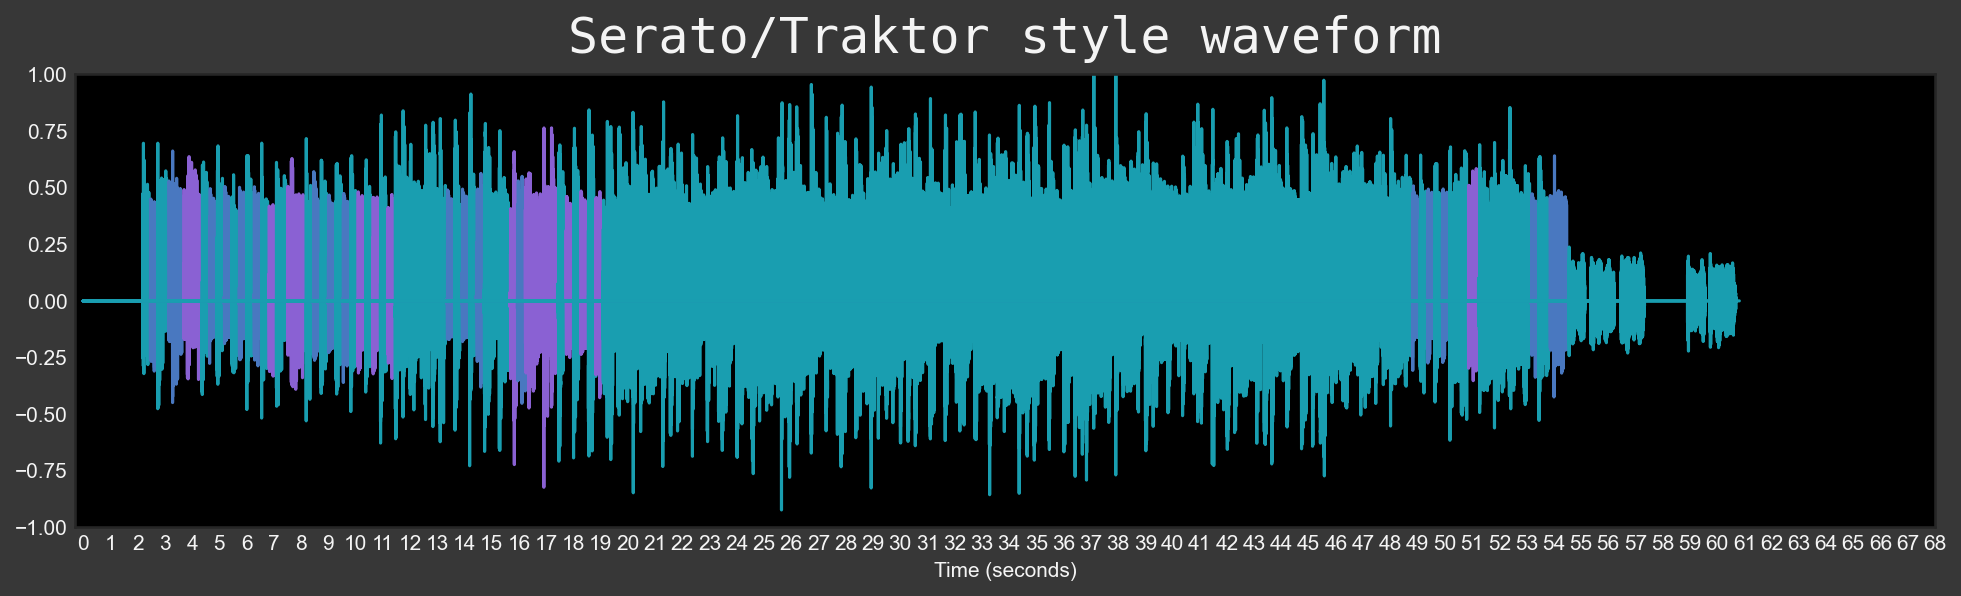

In [29]:
sr=44100
s, sr = librosa.load('Files/py5-fullMix.wav', sr=sr)
vizSerato(s, sr=sr)